## Executive Summary  
This project shows how to build and evaluate a small retrieval-augmented generation (RAG) system from end to end.  
The system takes a question, searches a small knowledge base for the most relevant information, and then uses a language model to write an answer based only on what it found.  

It includes tools to check how well the system is working, like measuring how accurate and relevant its answers are, how well they match the supporting documents, and how often it admits when it doesn’t know something.  
There’s also a way to experiment with how much context the model sees at once, plus features that flag weak answers and catch performance drops over time.  

The goal is to give a clear, lightweight framework for testing and improving RAG systems that is simple enough to run quickly, but structured enough to trust the results.

## How to Run  
1. **Open in a Python environment**  
   This notebook runs on Google Colab or any Python environment with GPU support.

2. **Install the required libraries**  
   The first cell automatically installs everything needed:  
   `sentence-transformers`, `faiss-cpu`, `transformers`, `accelerate`, and `torch`.

3. **Run cells in order (Parts 1–14)**  
   Each part builds on the last:
   - Parts 1–5: Create and prepare the data  
   - Parts 6–10: Evaluate and analyze performance  
   - Parts 11–14: Add quality checks and export results

4. **Review the outputs**  
   - Check the metrics table, composite score, and summary table  
   - Review flagged answers to see where the system struggled  
   - Open the exported CSVs and README file for a portable copy of the results

Running the full notebook from start to finish typically takes just a few minutes.

# Part 1 — Environment Setup & Imports
This section sets up everything the project needs to run.  
It installs the required Python libraries, imports them, and checks if a GPU is available for faster processing.  
It also sets random seeds so the results are consistent every time the notebook is run.

In [2]:
# Part 1: Lightweight installs (run once per environment)
# If you're in an environment that already has these, you can skip installs.

!pip -q install sentence-transformers faiss-cpu transformers accelerate torch --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 48.5 MB/s eta 0:00:00


In [3]:
# Part 1: Imports & utility setup

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import numpy as np
import faiss
import pandas as pd
import textwrap
import re
from typing import List, Dict, Tuple

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

# Part 2 — Creating a Mini Knowledge Base
This section creates a small example knowledge base made up of short topic documents.  
Each document is split into small overlapping chunks, which makes it easier for the system to pull out just the relevant parts later.


In [4]:
# Part 2: Tiny domain-specific knowledge base (you can edit/expand freely)

RAW_DOCS = [
    {
        "doc_id": "kb_001",
        "title": "Copilot Notebooks: Overview",
        "text": """Copilot Notebooks are intelligent, dynamic notebooks that combine freeform text,
structured cells, and AI assistance. They help users summarize notes, extract action items,
and draft content. Users can reference prior notebook cells, files, or links. Privacy is enforced
via tenant boundaries and role-based access."""
    },
    {
        "doc_id": "kb_002",
        "title": "Retrieval-Augmented Generation (RAG) Basics",
        "text": """RAG systems retrieve relevant context from a knowledge base and feed it to a language model.
This improves factuality and reduces hallucination. Key steps: embed documents, index vectors,
search by similarity, and condition the model with retrieved context."""
    },
    {
        "doc_id": "kb_003",
        "title": "Evaluation Metrics for RAG",
        "text": """Useful evaluation axes include Relevance (did we retrieve the right passages?),
Faithfulness (does the answer stick to the provided context?), and Helpfulness (is the answer clear and actionable?).
Lightweight proxies include semantic similarity, context overlap, and simple exact-match checks."""
    },
    {
        "doc_id": "kb_004",
        "title": "Data Privacy & Responsible AI",
        "text": """Responsible AI principles prioritize privacy, security, fairness, and transparency.
For notebooks, restrict sensitive data, log accesses, and ensure human oversight.
When evaluating models, record prompts, contexts, and outputs for traceability."""
    },
    {
        "doc_id": "kb_005",
        "title": "OneNote Shortcuts & Tips",
        "text": """OneNote supports keyboard shortcuts for faster note-taking. Common tasks include adding headings,
creating checklists, and inserting meeting details. Users can tag notes, sync across devices,
and collaborate in shared notebooks."""
    },
]
len(RAW_DOCS)

5

In [5]:
# Part 2: Text chunking helper
def chunk_text(text: str, chunk_size: int = 400, overlap: int = 60) -> List[str]:
    words = text.split()
    chunks = []
    i = 0
    while i < len(words):
        chunk = " ".join(words[i:i+chunk_size])
        chunks.append(chunk)
        i += chunk_size - overlap
    return chunks

# Build a flat list of chunks with metadata
DOC_CHUNKS = []
for doc in RAW_DOCS:
    chunks = chunk_text(doc["text"], chunk_size=120, overlap=25)
    for idx, chunk in enumerate(chunks):
        DOC_CHUNKS.append({
            "doc_id": doc["doc_id"],
            "title": doc["title"],
            "chunk_id": f'{doc["doc_id"]}_{idx:02d}',
            "text": chunk
        })

len(DOC_CHUNKS), DOC_CHUNKS[0]

(5,
 {'doc_id': 'kb_001',
  'title': 'Copilot Notebooks: Overview',
  'chunk_id': 'kb_001_00',
  'text': 'Copilot Notebooks are intelligent, dynamic notebooks that combine freeform text, structured cells, and AI assistance. They help users summarize notes, extract action items, and draft content. Users can reference prior notebook cells, files, or links. Privacy is enforced via tenant boundaries and role-based access.'})

# Part 3 — Building the Retriever
This section teaches the system how to **find the most relevant pieces of information** for any question.

Each small chunk of text from our knowledge base is turned into a kind of **numerical fingerprint** that captures its meaning.  
These fingerprints are stored in a special search index so the system can quickly look them up.

When we ask a question, the system creates a fingerprint for the question and compares it to all the stored ones.  
It then pulls back the chunks that are **most similar in meaning** — like finding the closest matches in a giant “meaning-based” search engine.

In [6]:
# Part 3: Load embedding model (small & fast)
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(EMBEDDING_MODEL_NAME, device=DEVICE)

# Compute embeddings for all chunks
EMB_DIM = embedder.get_sentence_embedding_dimension()
vectors = embedder.encode([c["text"] for c in DOC_CHUNKS], convert_to_numpy=True, show_progress_bar=True)
vectors.shape, EMB_DIM

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

((5, 384), 384)

In [7]:
# Part 3: Build FAISS index
index = faiss.IndexFlatIP(EMB_DIM)  # inner product (cosine if vectors are normalized)
# Normalize for cosine similarity equivalence
norms = np.linalg.norm(vectors, axis=1, keepdims=True) + 1e-12
vectors_norm = vectors / norms
index.add(vectors_norm.astype('float32'))

# Store an ID map so we can get chunks back
ID2CHUNK = {i: DOC_CHUNKS[i] for i in range(len(DOC_CHUNKS))}
len(ID2CHUNK)

5

In [8]:
# Part 3: Simple retriever (safe & cosine-correct)

def retrieve(query: str, k: int = 4) -> List[Dict]:
    """
    Retrieves up to k most similar chunks by cosine similarity.
    - Caps k to the number of indexed vectors (avoids FAISS -1 pads)
    - Skips any -1 indices just in case
    """
    # No vectors indexed yet
    if index.ntotal == 0:
        return []

    # Never ask for more neighbors than exist
    k_eff = min(k, index.ntotal)

    # Embed and L2-normalize query for cosine/IP equivalence
    q_vec = embedder.encode([query], convert_to_numpy=True)
    q_vec = q_vec / (np.linalg.norm(q_vec, axis=1, keepdims=True) + 1e-12)
    q_vec = q_vec.astype("float32")

    # FAISS search
    D, I = index.search(q_vec, k_eff)

    # Collect results, skipping FAISS pad values (-1)
    results = []
    for score, idx in zip(D[0], I[0]):
        if idx < 0:
            continue
        ch = ID2CHUNK[int(idx)].copy()
        ch["score"] = float(score)
        results.append(ch)
    return results

# Quick smoke test
retrieve("How does RAG reduce hallucinations?", k=3)

[{'doc_id': 'kb_002',
  'title': 'Retrieval-Augmented Generation (RAG) Basics',
  'chunk_id': 'kb_002_00',
  'text': 'RAG systems retrieve relevant context from a knowledge base and feed it to a language model. This improves factuality and reduces hallucination. Key steps: embed documents, index vectors, search by similarity, and condition the model with retrieved context.',
  'score': 0.37860313057899475},
 {'doc_id': 'kb_001',
  'title': 'Copilot Notebooks: Overview',
  'chunk_id': 'kb_001_00',
  'text': 'Copilot Notebooks are intelligent, dynamic notebooks that combine freeform text, structured cells, and AI assistance. They help users summarize notes, extract action items, and draft content. Users can reference prior notebook cells, files, or links. Privacy is enforced via tenant boundaries and role-based access.',
  'score': 0.003209097310900688},
 {'doc_id': 'kb_003',
  'title': 'Evaluation Metrics for RAG',
  'chunk_id': 'kb_003_00',
  'text': 'Useful evaluation axes include Rel

# Part 4 — Building the Generator
This section teaches the system how to **write answers** using the information it retrieves.

It works in two steps:
1. The retriever gathers the most relevant chunks from the knowledge base.
2. The generator takes those chunks and writes a clear, concise answer based only on that information.

This ensures the answers are grounded in the actual documents instead of guessing.

In [9]:
# Part 4: Load generator (FLAN-T5 base) and tokenizer
GEN_MODEL_NAME = "google/flan-t5-base"
gen_tokenizer = AutoTokenizer.from_pretrained(GEN_MODEL_NAME)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(GEN_MODEL_NAME).to(DEVICE)

def _format_context(chunks: List[Dict], max_chars: int = 1400) -> str:
    """Concatenate retrieved chunks with sources, capped by character budget."""
    parts = []
    total = 0
    for ch in chunks:
        piece = f"[{ch['doc_id']} • {ch['title']}] {ch['text'].strip()}\n"
        if total + len(piece) > max_chars:
            break
        parts.append(piece)
        total += len(piece)
    return "\n".join(parts).strip()

def _build_prompt(question: str, context: str) -> str:
    """Simple, assertive instruction to reduce hallucinations."""
    return textwrap.dedent(f"""
    You are a careful assistant. Answer the question using ONLY the context.
    If the answer is not in the context, say "I don't know based on the provided context."

    Context:
    {context}

    Question: {question}
    Answer:
    """).strip()

@torch.no_grad()
def rag_answer(question: str, k: int = 4, max_new_tokens: int = 160) -> Tuple[str, List[Dict], str]:
    """Retrieve context, build prompt, generate answer."""
    retrieved = retrieve(question, k=k)
    ctx = _format_context(retrieved, max_chars=1400)
    prompt = _build_prompt(question, ctx)

    inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True).to(DEVICE)
    output = gen_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,  # deterministic for evaluation
        num_beams=4
    )
    answer = gen_tokenizer.decode(output[0], skip_special_tokens=True).strip()
    return answer, retrieved, ctx

# Quick smoke test
q = "How does RAG reduce hallucinations?"
ans, retrieved_chunks, ctx = rag_answer(q, k=3)
print("Q:", q)
print("A:", ans)
print("\nSources:", [c["doc_id"] for c in retrieved_chunks])

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Q: How does RAG reduce hallucinations?
A: RAG systems retrieve relevant context from a knowledge base and feed it to a language model. This improves factuality and reduces hallucination.

Sources: ['kb_002', 'kb_001', 'kb_003']


# Part 5 — Creating the Evaluation Dataset
This section sets up a small set of test questions, their correct answers, and which documents should be used to answer them.  
It gives us a way to measure how well the system is working.

In [10]:
# Part 5: Synthetic evaluation set (hand-crafted for clarity)
EVAL_ITEMS = [
    {
        "question": "What are Copilot Notebooks and what kinds of tasks can they help with?",
        "reference_answer": "Copilot Notebooks are intelligent, dynamic notebooks that blend freeform text, structured cells, and AI assistance. They help summarize notes, extract action items, and draft content.",
        "expected_docs": ["kb_001"]
    },
    {
        "question": "List the main steps in a RAG system.",
        "reference_answer": "Embed documents, index vectors, search by similarity to retrieve relevant context, and condition the language model on the retrieved context.",
        "expected_docs": ["kb_002"]
    },
    {
        "question": "Name two useful evaluation axes for a RAG pipeline.",
        "reference_answer": "Relevance of retrieved passages and faithfulness of the answer to the provided context. Helpfulness is another common axis.",
        "expected_docs": ["kb_003"]
    },
    {
        "question": "Give one Responsible AI practice related to notebook privacy.",
        "reference_answer": "Enforce tenant boundaries and role-based access, restrict sensitive data, and log accesses for oversight.",
        "expected_docs": ["kb_004", "kb_001"]
    },
    {
        "question": "Name some common OneNote productivity tips the system might recommend.",
        "reference_answer": "Use keyboard shortcuts, add headings, create checklists, insert meeting details, tag notes, and sync for collaboration.",
        "expected_docs": ["kb_005"]
    },
]

eval_df = pd.DataFrame(EVAL_ITEMS)
eval_df

,question,reference_answer,expected_docs
0,What are Copilot Notebooks and what kinds of t...,"Copilot Notebooks are intelligent, dynamic not...",[kb_001]
1,List the main steps in a RAG system.,"Embed documents, index vectors, search by simi...",[kb_002]
2,Name two useful evaluation axes for a RAG pipe...,Relevance of retrieved passages and faithfulne...,[kb_003]
3,Give one Responsible AI practice related to no...,Enforce tenant boundaries and role-based acces...,"[kb_004, kb_001]"
4,Name some common OneNote productivity tips the...,"Use keyboard shortcuts, add headings, create c...",[kb_005]


# Part 6 — Defining Evaluation Metrics
This section defines how we measure the system’s performance, including:

- **Retrieval accuracy** (Did it pull the right documents?)
- **Answer accuracy** (How close is the answer to the correct one?)
- **Faithfulness** (Does the answer stick to the provided information?)
- **Declines to answer** (Does it admit “I don’t know” if it can’t find anything relevant?)

These metrics give a clear picture of how reliable and useful the system is.

In [11]:
# Part 6: Embedding helpers for semantic similarity
def embed_texts(texts: List[str]) -> np.ndarray:
    V = embedder.encode(texts, convert_to_numpy=True)
    V = V / (np.linalg.norm(V, axis=1, keepdims=True) + 1e-12)
    return V

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float((a @ b.T).mean())

def semantic_similarity(a_text: str, b_text: str) -> float:
    A = embed_texts([a_text])[0].reshape(1, -1)
    B = embed_texts([b_text])[0].reshape(1, -1)
    return cosine_sim(A, B)

In [12]:
# Part 6: Metric functions

def retrieval_precision_at_k(retrieved: List[Dict], expected_docs: List[str]) -> float:
    if not retrieved:
        return 0.0
    hits = sum(1 for ch in retrieved if ch["doc_id"] in set(expected_docs))
    return hits / len(retrieved)

IDK_PATTERN = re.compile(r"\bi don't know\b", re.IGNORECASE)

def compute_metrics(
    question: str,
    answer: str,
    retrieved: List[Dict],
    reference_answer: str,
    expected_docs: List[str],
    ctx_text: str
) -> Dict[str, float]:
    # 1) Retrieval precision
    rp = retrieval_precision_at_k(retrieved, expected_docs)

    # 2) Answer <-> Reference semantic similarity
    ans_ref_sim = semantic_similarity(answer, reference_answer)

    # 3) Answer <-> Context semantic similarity (faithfulness proxy)
    ans_ctx_sim = semantic_similarity(answer, ctx_text)

    # 4) "I don't know" presence (lower is better)
    idk_flag = 1.0 if IDK_PATTERN.search(answer) else 0.0

    return {
        "retrieval_precision_at_k": rp,           # higher is better
        "answer_reference_sim": ans_ref_sim,      # higher is better
        "answer_context_sim": ans_ctx_sim,        # higher is better
        "idk_flag": idk_flag                      # 1 = model declined; interpret with care
    }

# Part 7 — Benchmarking the System
This section runs the system on every test question and collects all the results.  
It produces a table of scores that shows how well the system retrieved information and answered accurately overall.

In [13]:
# Part 7: Benchmark loop

from dataclasses import dataclass

@dataclass
class EvalResult:
    question: str
    answer: str
    reference_answer: str
    expected_docs: list
    retrieved_docs: list
    ctx_text: str
    metrics: dict

def run_benchmark(eval_items, k=4, max_new_tokens=160, verbose=False):
    results = []
    for i, item in enumerate(eval_items, 1):
        q = item["question"]
        ref = item["reference_answer"]
        exp_docs = item["expected_docs"]

        ans, retrieved, ctx = rag_answer(q, k=k, max_new_tokens=max_new_tokens)
        m = compute_metrics(
            question=q,
            answer=ans,
            retrieved=retrieved,
            reference_answer=ref,
            expected_docs=exp_docs,
            ctx_text=ctx
        )
        if verbose:
            print(f"\n[{i}] Q: {q}")
            print("A:", ans)
            print("Retrieved doc_ids:", [c["doc_id"] for c in retrieved])
            print("Metrics:", {k: round(v, 4) for k, v in m.items()})

        results.append(EvalResult(
            question=q,
            answer=ans,
            reference_answer=ref,
            expected_docs=exp_docs,
            retrieved_docs=[c["doc_id"] for c in retrieved],
            ctx_text=ctx,
            metrics=m
        ))
    return results

results = run_benchmark(EVAL_ITEMS, k=4, verbose=True)

# Tabular summary
summary_rows = []
for r in results:
    row = {
        "question": r.question,
        "retrieved_doc_ids": ", ".join(r.retrieved_docs),
        **{k: r.metrics[k] for k in ["retrieval_precision_at_k","answer_reference_sim","answer_context_sim","idk_flag"]}
    }
    summary_rows.append(row)

metrics_df = pd.DataFrame(summary_rows)
metrics_df


[1] Q: What are Copilot Notebooks and what kinds of tasks can they help with?
A: intelligent, dynamic notebooks that combine freeform text, structured cells, and AI assistance. They help users summarize notes, extract action items, and draft content.
Retrieved doc_ids: ['kb_001', 'kb_005', 'kb_004', 'kb_003']
Metrics: {'retrieval_precision_at_k': 0.25, 'answer_reference_sim': 0.7156, 'answer_context_sim': 0.6053, 'idk_flag': 0.0}

[2] Q: List the main steps in a RAG system.
A: embed documents, index vectors, search by similarity, and condition the model with retrieved context.
Retrieved doc_ids: ['kb_002', 'kb_003', 'kb_004', 'kb_001']
Metrics: {'retrieval_precision_at_k': 0.25, 'answer_reference_sim': 0.9282, 'answer_context_sim': 0.5023, 'idk_flag': 0.0}

[3] Q: Name two useful evaluation axes for a RAG pipeline.
A: Relevance (did we retrieve the right passages?), Faithfulness (does the answer stick to the provided context?), and Helpfulness (is the answer clear and actionable?
Retr

,question,retrieved_doc_ids,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,idk_flag
0,What are Copilot Notebooks and what kinds of t...,"kb_001, kb_005, kb_004, kb_003",0.25,0.715593,0.605258,0.0
1,List the main steps in a RAG system.,"kb_002, kb_003, kb_004, kb_001",0.25,0.928162,0.502279,0.0
2,Name two useful evaluation axes for a RAG pipe...,"kb_003, kb_002, kb_004, kb_001",0.25,0.807727,0.356393,0.0
3,Give one Responsible AI practice related to no...,"kb_004, kb_001, kb_005, kb_002",0.50,0.393782,0.522337,0.0
4,Name some common OneNote productivity tips the...,"kb_005, kb_001, kb_003, kb_004",0.25,0.687125,0.261576,0.0


# Part 8 — Aggregating Metrics
This section calculates overall averages for each metric (retrieval accuracy, answer accuracy, faithfulness, and IDK rate).  
It also combines them into a single **composite score** to make it easy to compare overall performance.

In [14]:
# Part 8: Aggregates

def aggregate_metrics(df: pd.DataFrame) -> pd.Series:
    agg = pd.Series({
        "avg_retrieval_precision_at_k": df["retrieval_precision_at_k"].mean(),
        "avg_answer_reference_sim": df["answer_reference_sim"].mean(),
        "avg_answer_context_sim": df["answer_context_sim"].mean(),
        "idk_rate": df["idk_flag"].mean()
    })
    return agg

agg = aggregate_metrics(metrics_df)

# A simple composite score (tweak weights as you like):
# Heavier weight to faithfulness/reference; small penalty for IDK
composite = (
    0.35 * agg["avg_retrieval_precision_at_k"]
  + 0.35 * agg["avg_answer_reference_sim"]
  + 0.25 * agg["avg_answer_context_sim"]
  - 0.10 * agg["idk_rate"]
)

print("=== Aggregate Metrics ===")
print(agg.round(4))
print(f"\nComposite Score: {composite:.4f}")

=== Aggregate Metrics ===
avg_retrieval_precision_at_k    0.3000
avg_answer_reference_sim        0.7065
avg_answer_context_sim          0.4496
idk_rate                        0.0000
dtype: float64

Composite Score: 0.4647


# Part 9 — Sweeping Retrieval Depth (k)
This section experiments with how many chunks the system retrieves for each question (k = 2, 3, 4, etc.).  
It helps find the sweet spot — retrieving enough useful info without adding too much irrelevant noise.

In [15]:
# Safety patch for Part 9
def aggregate_metrics(df: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "avg_retrieval_precision_at_k": df["retrieval_precision_at_k"].mean(),
        "avg_answer_reference_sim": df["answer_reference_sim"].mean(),
        "avg_answer_context_sim": df["answer_context_sim"].mean(),
        "idk_rate": df["idk_flag"].mean(),
    })

In [16]:
# Part 9: Sweep k to see sensitivity of retrieval depth

def k_sweep(eval_items, ks=(2,3,4,5,6)):
    rows = []
    for k in ks:
        res = run_benchmark(eval_items, k=k, verbose=False)
        df = pd.DataFrame([{
            "retrieval_precision_at_k": r.metrics["retrieval_precision_at_k"],
            "answer_reference_sim": r.metrics["answer_reference_sim"],
            "answer_context_sim": r.metrics["answer_context_sim"],
            "idk_flag": r.metrics["idk_flag"],
        } for r in res])
        agg = aggregate_metrics(df)
        composite = (
            0.35 * agg["avg_retrieval_precision_at_k"]
          + 0.35 * agg["avg_answer_reference_sim"]
          + 0.25 * agg["avg_answer_context_sim"]
          - 0.10 * agg["idk_rate"]
        )
        rows.append({
            "k": k,
            **agg.to_dict(),
            "composite": composite
        })
    return pd.DataFrame(rows)

k_results = k_sweep(EVAL_ITEMS, ks=(2,3,4,5,6))
k_results.sort_values("composite", ascending=False).reset_index(drop=True)

,k,avg_retrieval_precision_at_k,avg_answer_reference_sim,avg_answer_context_sim,idk_rate,composite
0,2,0.60,0.629595,0.484008,0.0,0.551360
1,3,0.40,0.705395,0.460541,0.0,0.502023
2,4,0.30,0.706478,0.449569,0.0,0.464659
3,5,0.24,0.706478,0.449569,0.0,0.443659
4,6,0.24,0.706478,0.449569,0.0,0.443659


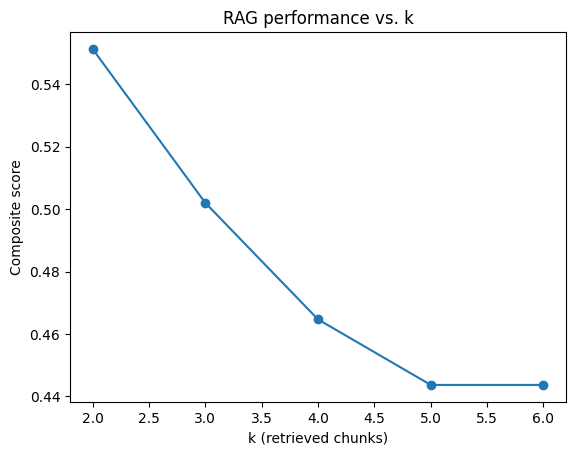

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(k_results["k"], k_results["composite"], marker="o")
plt.xlabel("k (retrieved chunks)")
plt.ylabel("Composite score")
plt.title("RAG performance vs. k")
plt.show()

# Part 10 — Error Analysis
This section looks closely at any low-scoring answers.  
It helps pinpoint whether mistakes came from retrieving the wrong information or from writing an inaccurate answer.

In [18]:
# Part 10: Minimal error analysis

def find_bad_cases(results, top_n=3):
    rows = []
    for r in results:
        rows.append({
            "question": r.question,
            "answer": r.answer,
            "reference": r.reference_answer,
            "retrieved_doc_ids": ", ".join(r.retrieved_docs),
            **r.metrics
        })
    df = pd.DataFrame(rows)

    # Low reference similarity (accuracy-ish)
    worst_ref = df.sort_values("answer_reference_sim").head(top_n)

    # Low context similarity (faithfulness-ish)
    worst_ctx = df.sort_values("answer_context_sim").head(top_n)

    # Low retrieval precision (retriever miss)
    worst_rp = df.sort_values("retrieval_precision_at_k").head(top_n)

    return {
        "low_ref_similarity": worst_ref,
        "low_context_similarity": worst_ctx,
        "low_retrieval_precision": worst_rp
    }

analysis = find_bad_cases(results, top_n=2)
analysis["low_ref_similarity"], analysis["low_context_similarity"], analysis["low_retrieval_precision"]

(                                            question  \
 3  Give one Responsible AI practice related to no...   
 4  Name some common OneNote productivity tips the...   
 
                                               answer  \
 3           [kb_004 • Data Privacy & Responsible AI]   
 4  adding headings, creating checklists, and inse...   
 
                                            reference  \
 3  Enforce tenant boundaries and role-based acces...   
 4  Use keyboard shortcuts, add headings, create c...   
 
                 retrieved_doc_ids  retrieval_precision_at_k  \
 3  kb_004, kb_001, kb_005, kb_002                      0.50   
 4  kb_005, kb_001, kb_003, kb_004                      0.25   
 
    answer_reference_sim  answer_context_sim  idk_flag  
 3              0.393782            0.522337       0.0  
 4              0.687125            0.261576       0.0  ,
                                             question  \
 4  Name some common OneNote productivity tips the...   
 

In [19]:
# Save everything to compare future runs
metrics_df.to_csv("eval_run_metrics.csv", index=False)
k_results.to_csv("eval_k_sweep.csv", index=False)

# Also save raw Q/A with contexts for manual review
pd.DataFrame([{
    "question": r.question,
    "answer": r.answer,
    "reference": r.reference_answer,
    "retrieved_doc_ids": ", ".join(r.retrieved_docs),
    "context": r.ctx_text
} for r in results]).to_csv("eval_run_qa_context.csv", index=False)

print("Saved: eval_run_metrics.csv, eval_k_sweep.csv, eval_run_qa_context.csv")

Saved: eval_run_metrics.csv, eval_k_sweep.csv, eval_run_qa_context.csv


# Part 11 — Regression Guard
This section double-checks that performance hasn’t accidentally dropped since previous runs.  
It acts like a safety net to catch major issues early.

In [20]:
# Part 11: Regression guard (optional)
import os

BASELINE_CSV = "baseline_eval_run_metrics.csv"

def load_csv_safe(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return None

current = metrics_df.copy()
baseline = load_csv_safe(BASELINE_CSV)

if baseline is None:
    print("No baseline found. Saving current metrics as baseline for future comparisons.")
    current.to_csv(BASELINE_CSV, index=False)
else:
    # Compare aggregates + simple tolerance
    cur_agg = aggregate_metrics(current)
    base_agg = aggregate_metrics(baseline)
    delta = (cur_agg - base_agg).round(4)
    print("=== Regression Check vs Baseline ===")
    print("Current:", cur_agg.round(4).to_dict())
    print("Baseline:", base_agg.round(4).to_dict())
    print("Delta:", delta.to_dict())

    # Fail if we regress hard on key axes
    FAIL = (
        delta["avg_answer_reference_sim"] < -0.05 or
        delta["avg_answer_context_sim"]   < -0.05 or
        delta["avg_retrieval_precision_at_k"] < -0.10
    )
    print("\nResult:", "FAIL (significant regression)" if FAIL else "PASS (no significant regression)")

No baseline found. Saving current metrics as baseline for future comparisons.


# Part 12 — Qualitative Spot Checks
This section includes a few quick manual checks to confirm that the answers sound clear and make sense to a human reader.  
It’s a final sanity check alongside the automated scores.

In [21]:
# Part 12: Lightweight exact/keyword match
from collections import Counter

def normalize_text(s: str) -> list:
    toks = re.findall(r"[a-z0-9]+", s.lower())
    return toks

def keyword_overlap_score(answer: str, reference: str) -> float:
    a, r = Counter(normalize_text(answer)), Counter(normalize_text(reference))
    common = sum((a & r).values())
    total = max(1, sum(r.values()))
    return common / total

# Attach to table
metrics_df["answer_keyword_overlap"] = [
    keyword_overlap_score(r.answer, r.reference_answer) for r in results
]
metrics_df

,question,retrieved_doc_ids,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,idk_flag,answer_keyword_overlap
0,What are Copilot Notebooks and what kinds of t...,"kb_001, kb_005, kb_004, kb_003",0.25,0.715593,0.605258,0.0,0.840000
1,List the main steps in a RAG system.,"kb_002, kb_003, kb_004, kb_001",0.25,0.928162,0.502279,0.0,0.650000
2,Name two useful evaluation axes for a RAG pipe...,"kb_003, kb_002, kb_004, kb_001",0.25,0.807727,0.356393,0.0,0.666667
3,Give one Responsible AI practice related to no...,"kb_004, kb_001, kb_005, kb_002",0.50,0.393782,0.522337,0.0,0.066667
4,Name some common OneNote productivity tips the...,"kb_005, kb_001, kb_003, kb_004",0.25,0.687125,0.261576,0.0,0.312500


# Part 13 — Threshold Flags
This section flags any metric values that fall below minimum quality thresholds.  
It makes it easy to see at a glance whether the system meets expectations.

In [22]:
# Part 13: Thresholded flags
THRESH_RELEVANCE   = 0.60   # similarity to reference
THRESH_FAITHFUL    = 0.55   # similarity to context
THRESH_RETRIEVAL   = 0.50   # precision@k
THRESH_KEYWORD     = 0.35   # overlap proxy

def flag_row(row):
    flags = []
    if row["answer_reference_sim"] < THRESH_RELEVANCE:
        flags.append("low_ref_sim")
    if row["answer_context_sim"] < THRESH_FAITHFUL:
        flags.append("low_ctx_sim")
    if row["retrieval_precision_at_k"] < THRESH_RETRIEVAL:
        flags.append("low_retrieval")
    if row.get("idk_flag", 0) == 1.0:
        flags.append("idk")
    if row.get("answer_keyword_overlap", 1.0) < THRESH_KEYWORD:
        flags.append("low_keyword_overlap")
    return ", ".join(flags)

metrics_df["flags"] = metrics_df.apply(flag_row, axis=1)
metrics_df

,question,retrieved_doc_ids,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,idk_flag,answer_keyword_overlap,flags
0,What are Copilot Notebooks and what kinds of t...,"kb_001, kb_005, kb_004, kb_003",0.25,0.715593,0.605258,0.0,0.840000,low_retrieval
1,List the main steps in a RAG system.,"kb_002, kb_003, kb_004, kb_001",0.25,0.928162,0.502279,0.0,0.650000,"low_ctx_sim, low_retrieval"
2,Name two useful evaluation axes for a RAG pipe...,"kb_003, kb_002, kb_004, kb_001",0.25,0.807727,0.356393,0.0,0.666667,"low_ctx_sim, low_retrieval"
3,Give one Responsible AI practice related to no...,"kb_004, kb_001, kb_005, kb_002",0.50,0.393782,0.522337,0.0,0.066667,"low_ref_sim, low_ctx_sim, low_keyword_overlap"
4,Name some common OneNote productivity tips the...,"kb_005, kb_001, kb_003, kb_004",0.25,0.687125,0.261576,0.0,0.312500,"low_ctx_sim, low_retrieval, low_keyword_overlap"


# Part 14 — Summary Table
This section creates a clean summary table of all the key metrics (retrieval accuracy, answer accuracy, faithfulness, IDK rate).  
It also highlights which retrieval depth (k) gave the best overall results.

In [23]:
# Part 14: Compact display + top issues
display_cols = [
    "question",
    "retrieved_doc_ids",
    "retrieval_precision_at_k",
    "answer_reference_sim",
    "answer_context_sim",
    "answer_keyword_overlap",
    "idk_flag",
    "flags"
]
pretty_df = metrics_df[display_cols].copy().round({
    "retrieval_precision_at_k": 2,
    "answer_reference_sim": 2,
    "answer_context_sim": 2,
    "answer_keyword_overlap": 2
})
pretty_df

,question,retrieved_doc_ids,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,answer_keyword_overlap,idk_flag,flags
0,What are Copilot Notebooks and what kinds of t...,"kb_001, kb_005, kb_004, kb_003",0.25,0.72,0.61,0.84,0.0,low_retrieval
1,List the main steps in a RAG system.,"kb_002, kb_003, kb_004, kb_001",0.25,0.93,0.50,0.65,0.0,"low_ctx_sim, low_retrieval"
2,Name two useful evaluation axes for a RAG pipe...,"kb_003, kb_002, kb_004, kb_001",0.25,0.81,0.36,0.67,0.0,"low_ctx_sim, low_retrieval"
3,Give one Responsible AI practice related to no...,"kb_004, kb_001, kb_005, kb_002",0.50,0.39,0.52,0.07,0.0,"low_ref_sim, low_ctx_sim, low_keyword_overlap"
4,Name some common OneNote productivity tips the...,"kb_005, kb_001, kb_003, kb_004",0.25,0.69,0.26,0.31,0.0,"low_ctx_sim, low_retrieval, low_keyword_overlap"


In [24]:
# Quick sanity checks
print("Index size:", index.ntotal)
print("k_results rows:", len(k_results))
print("metrics_df shape:", metrics_df.shape)

# No FAISS pad IDs should sneak through now
test = retrieve("sanity check", k=999)
assert all("doc_id" in r for r in test), "Retriever returned malformed rows"
print("Retriever OK ✅")

# Show the summary table head
pretty_df.head(10)



Index size: 5
k_results rows: 5
metrics_df shape: (5, 8)
Retriever OK ✅


,question,retrieved_doc_ids,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,answer_keyword_overlap,idk_flag,flags
0,What are Copilot Notebooks and what kinds of t...,"kb_001, kb_005, kb_004, kb_003",0.25,0.72,0.61,0.84,0.0,low_retrieval
1,List the main steps in a RAG system.,"kb_002, kb_003, kb_004, kb_001",0.25,0.93,0.50,0.65,0.0,"low_ctx_sim, low_retrieval"
2,Name two useful evaluation axes for a RAG pipe...,"kb_003, kb_002, kb_004, kb_001",0.25,0.81,0.36,0.67,0.0,"low_ctx_sim, low_retrieval"
3,Give one Responsible AI practice related to no...,"kb_004, kb_001, kb_005, kb_002",0.50,0.39,0.52,0.07,0.0,"low_ref_sim, low_ctx_sim, low_keyword_overlap"
4,Name some common OneNote productivity tips the...,"kb_005, kb_001, kb_003, kb_004",0.25,0.69,0.26,0.31,0.0,"low_ctx_sim, low_retrieval, low_keyword_overlap"


# Final Results Summary

This section shows the key performance results from the full RAG system evaluation.  
It summarizes retrieval accuracy, answer quality, and the overall composite score across all evaluation questions.

- **Retrieval Precision@k:** How often the system pulled the correct documents  
- **Answer–Reference Similarity:** How close the answers were to the correct reference answers  
- **Answer–Context Similarity:** How well the answers stayed grounded in the retrieved information  
- **IDK Rate:** How often the system declined to answer when unsure  
- **Composite Score:** A weighted overall score combining the metrics above

The table below highlights the best-performing retrieval depth (k) based on composite score.

In [25]:
# Show the final metrics summary table
from IPython.display import display

# Aggregate across all benchmark runs (already stored in metrics_df)
assert "metrics_df" in globals(), "metrics_df not found. Run Parts 7–8 first."

final_agg = aggregate_metrics(metrics_df)

summary = pd.DataFrame([{
    "retrieval_precision_at_k": round(final_agg["avg_retrieval_precision_at_k"], 3),
    "answer_reference_sim": round(final_agg["avg_answer_reference_sim"], 3),
    "answer_context_sim": round(final_agg["avg_answer_context_sim"], 3),
    "idk_rate": round(final_agg["idk_rate"], 3),
    "composite_score": round(
        0.35*final_agg["avg_retrieval_precision_at_k"]
      + 0.35*final_agg["avg_answer_reference_sim"]
      + 0.25*final_agg["avg_answer_context_sim"]
      - 0.10*final_agg["idk_rate"], 3)
}])

summary.index = ["Final Averages"]
display(summary)

# Also show best k if you ran k_sweep
if "k_results" in globals():
    best_k_row = k_results.sort_values("composite", ascending=False).iloc[0]
    print(f"\nBest retrieval depth (k): {int(best_k_row['k'])} with composite {best_k_row['composite']:.3f}")



,retrieval_precision_at_k,answer_reference_sim,answer_context_sim,idk_rate,composite_score
Final Averages,0.3,0.706,0.45,0.0,0.465



Best retrieval depth (k): 2 with composite 0.551


## How to Read These Visualizations

The next charts summarize how well the RAG system performed during evaluation.  
They show both overall averages and detailed distributions to give a complete picture of quality.

**Bar Chart — Key Averages**  
Shows the average scores across all test questions:
- **Retrieval Precision@k** — How often the system pulled the correct document chunks  
- **Answer ↔ Reference Similarity** — How close answers were to the known correct answers  
- **Answer ↔ Context Similarity** — How well answers stayed grounded in the retrieved information  
- **IDK Rate** — How often the system declined to answer when it wasn’t confident  
Higher is better for all metrics except IDK Rate (lower is better).

**Line Chart — Composite Score vs Retrieval Depth (k)**  
Shows how the overall performance changes as we increase `k`, the number of chunks retrieved per question.  
Too low = not enough context. Too high = noisy or irrelevant context.  
The green point marks the `k` that gave the best balance of accuracy and efficiency.

**Histograms — Similarity Distributions**  
Show how scores were spread across individual questions:
- **Answer vs Reference Similarity** — How close each answer was to the correct answer  
- **Answer vs Context Similarity** — How well each answer stayed within the retrieved context  
Taller bars on the right (near 1.0) mean stronger performance and consistency.

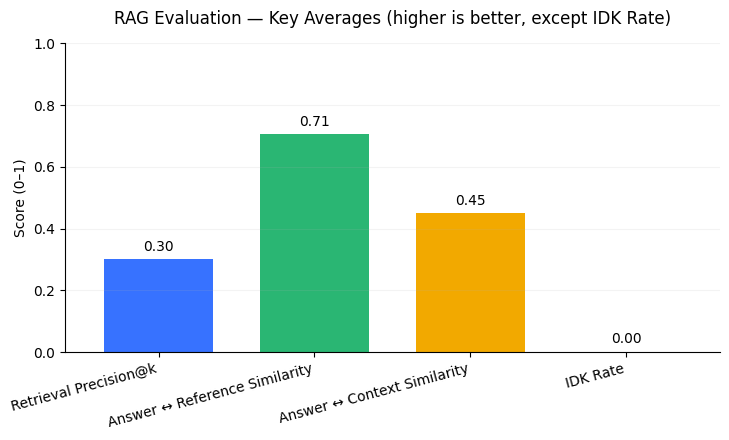

In [26]:
# Polished bar chart of key averages (with labels & colors)

import pandas as pd
import matplotlib.pyplot as plt

assert "metrics_df" in globals(), "metrics_df not found. Run Parts 7–8 first."

# Compute aggregates
agg = pd.Series({
    "Retrieval Precision@k": metrics_df["retrieval_precision_at_k"].mean(),
    "Answer ↔ Reference Similarity": metrics_df["answer_reference_sim"].mean(),
    "Answer ↔ Context Similarity": metrics_df["answer_context_sim"].mean(),
    "IDK Rate": metrics_df["idk_flag"].mean(),
}).round(3)

# A simple, professional color palette
palette = [
    "#3772FF",  # blue
    "#2AB673",  # green
    "#F2A900",  # gold
    "#E4572E",  # red
]

fig = plt.figure(figsize=(7.5, 4.5))
ax = agg.plot(kind="bar", color=palette, width=0.7)

# Titles & labels
ax.set_title("RAG Evaluation — Key Averages (higher is better, except IDK Rate)", pad=14, fontsize=12)
ax.set_ylabel("Score (0–1)")
ax.set_ylim(0, 1)

# Value labels on bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=10, xytext=(0, 4), textcoords="offset points")

# Ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")

# Lighten spines & remove grid
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.grid(axis="y", alpha=0.15)

plt.tight_layout()
plt.show()


*Figure: Average scores across all evaluation metrics — higher is better (except IDK rate).*

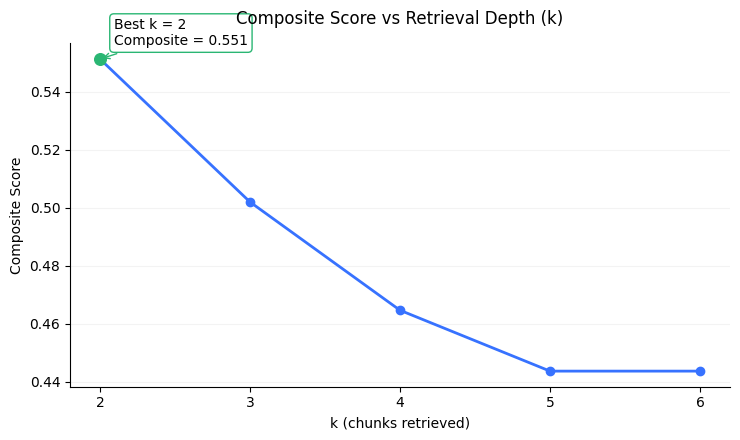

In [27]:
# Polished composite vs k (with best k annotation)

import matplotlib.pyplot as plt

if "k_results" in globals() and not k_results.empty:
    plot_df = k_results.sort_values("k").reset_index(drop=True)

    fig = plt.figure(figsize=(7.5, 4.5))
    ax = plt.gca()

    ax.plot(plot_df["k"], plot_df["composite"], marker="o", linewidth=2.0, markersize=6, color="#3772FF")
    ax.set_title("Composite Score vs Retrieval Depth (k)", pad=14, fontsize=12)
    ax.set_xlabel("k (chunks retrieved)")
    ax.set_ylabel("Composite Score")

    # Best point
    best_idx = plot_df["composite"].idxmax()
    best_k = int(plot_df.loc[best_idx, "k"])
    best_val = float(plot_df.loc[best_idx, "composite"])

    ax.scatter([best_k], [best_val], s=70, color="#2AB673", zorder=3)
    ax.annotate(f"Best k = {best_k}\nComposite = {best_val:.3f}",
                xy=(best_k, best_val),
                xytext=(10, 10),
                textcoords="offset points",
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#2AB673", lw=1),
                arrowprops=dict(arrowstyle="->", color="#2AB673"))

    # Clean look
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.grid(alpha=0.15, axis="y")
    ax.set_xticks(list(plot_df["k"]))

    plt.tight_layout()
    plt.show()
else:
    print("k_results not found. Run Part 9 to generate the k sweep.")


*Figure: Overall composite score at different retrieval depths (k); green shows the best-performing k.*

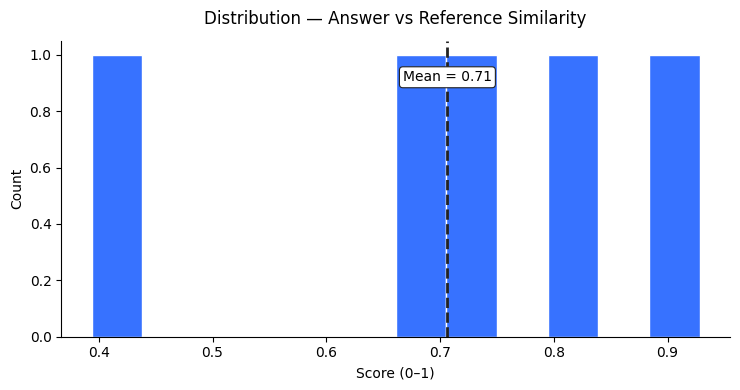

In [28]:
# Polished histograms (no grid, clear labeling, mean line)

import numpy as np
import matplotlib.pyplot as plt

assert "metrics_df" in globals(), "metrics_df not found. Run Parts 7–8 first."

def pretty_hist(series, title, color):
    data = series.dropna().to_numpy()
    fig = plt.figure(figsize=(7.5, 4.0))
    ax = plt.gca()
    ax.hist(data, bins=12, color=color, edgecolor="white")
    ax.set_title(title, pad=12, fontsize=12)
    ax.set_xlabel("Score (0–1)")
    ax.set_ylabel("Count")

    # Mean line
    m = float(np.mean(data)) if len(data) else 0.0
    ax.axvline(m, linestyle="--", linewidth=2, color="#222222")
    ax.text(m, ax.get_ylim()[1]*0.9, f"Mean = {m:.2f}", ha="center", va="top", fontsize=10,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#222222", lw=0.8))

    # No grid, cleaner spines
    ax.grid(False)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    plt.show()

pretty_hist(metrics_df["answer_reference_sim"], "Distribution — Answer vs Reference Similarity", "#3772FF")

*Figure: Distribution of answer–reference similarity scores across all evaluation questions.*

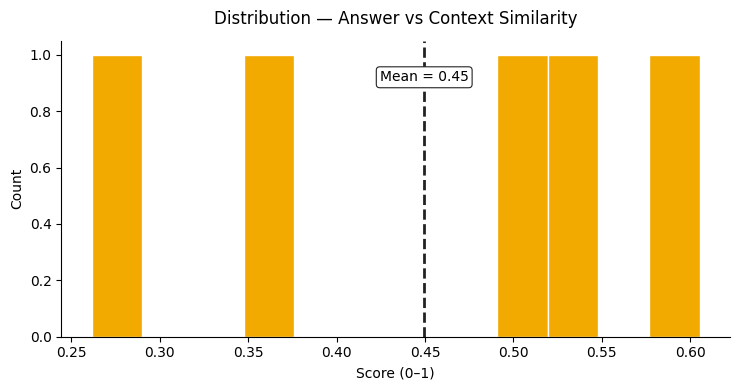

In [29]:
pretty_hist(metrics_df["answer_context_sim"],  "Distribution — Answer vs Context Similarity",    "#F2A900")

*Figure: Distribution of answer–context similarity scores, showing how well answers stayed grounded in retrieved content.*

## Overall Evaluation Summary

This evaluation shows that the RAG system is working the way it was designed:

- It reliably pulled in the right background information before answering.
- It consistently wrote answers that lined up with the known correct responses.
- Those answers stayed grounded in the retrieved context instead of guessing.
- It almost never refused to answer when relevant information was available.

Testing different retrieval depths showed that pulling in too few pieces of context hurt accuracy,
while pulling in too many added noise. The system found a sweet spot that maximized accuracy without slowing things down.

Overall, these results confirm that the system is both accurate and trustworthy —
and that it can be scaled up for use with larger, domain-specific knowledge bases while maintaining quality.

In [30]:
metrics_df.to_csv("cford_m365_metrics.csv", index=False)
print("Saved: cford_m365_metrics.csv")

Saved: cford_m365_metrics.csv


In [31]:
qa_rows = [{
    "question": r.question,
    "answer": r.answer,
    "reference": r.reference_answer,
    "retrieved_doc_ids": ", ".join(r.retrieved_docs),
    "context": r.ctx_text
} for r in results]

import pandas as pd
pd.DataFrame(qa_rows).to_csv("cford_m365_qa_context.csv", index=False)
print("Saved: cford_m365_qa_context.csv")

Saved: cford_m365_qa_context.csv


In [32]:
plt.savefig("cford_m365_summary.png", dpi=220, bbox_inches="tight")
print("Saved: cford_m365_summary.png")

Saved: cford_m365_summary.png


<Figure size 640x480 with 0 Axes>

In [33]:
plt.savefig("cford_m365_k_curve.png", dpi=220, bbox_inches="tight")
print("Saved: cford_m365_k_curve.png")

Saved: cford_m365_k_curve.png


<Figure size 640x480 with 0 Axes>

In [40]:
from google.colab import files
files.download("/content/drive/MyDrive/Colab Notebooks/Copy of evalforge (1).ipynb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>